In [1]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from functools import partial
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression

sys.path.append('../')
from src.utils import parallel_apply
from src.feature_extraction import add_features_in_group

sys.path.append('../')
from src.utils import parallel_apply
from src.feature_extraction import add_features_in_group
DIR = 'PATH/TO/YOUR/DATA'
DIR = '/mnt/ml-team/minerva/open-solutions/home-credit'

description = pd.read_csv(os.path.join(DIR,'data/HomeCredit_columns_description.csv'),encoding = 'latin1')
application = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/application_train.csv'))
pos_cash_balance = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/POS_CASH_balance.csv'))

In [2]:
pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


# Preprocessing
## Solution 3

# Feature Engineering
## Solution 3

### Aggregations

In [3]:
POS_CASH_BALANCE_AGGREGATION_RECIPIES = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['MONTHS_BALANCE',
                   'SK_DPD',
                   'SK_DPD_DEF'
                   ]:
        POS_CASH_BALANCE_AGGREGATION_RECIPIES.append((select, agg))
POS_CASH_BALANCE_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], POS_CASH_BALANCE_AGGREGATION_RECIPIES)]

In [4]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(POS_CASH_BALANCE_AGGREGATION_RECIPIES):
    group_object = pos_cash_balance.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        application = application.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [5]:
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_ID_CURR_min_SK_DPD_DEF,SK_ID_CURR_max_MONTHS_BALANCE,SK_ID_CURR_max_SK_DPD,SK_ID_CURR_max_SK_DPD_DEF,SK_ID_CURR_sum_MONTHS_BALANCE,SK_ID_CURR_sum_SK_DPD,SK_ID_CURR_sum_SK_DPD_DEF,SK_ID_CURR_var_MONTHS_BALANCE,SK_ID_CURR_var_SK_DPD,SK_ID_CURR_var_SK_DPD_DEF
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,-1.0,0.0,0.0,-190.0,0.0,0.0,31.666667,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,-18.0,0.0,0.0,-1226.0,0.0,0.0,607.137566,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,-24.0,0.0,0.0,-102.0,0.0,0.0,1.666667,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,-1.0,0.0,0.0,-202.0,0.0,0.0,36.947619,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,-1.0,0.0,0.0,-2220.0,0.0,0.0,510.265734,0.0,0.0


In [6]:
application_agg = application[groupby_aggregate_names + ['TARGET']]
application_agg_corr = abs(application_agg.corr())

In [7]:
application_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                            1.000000
SK_ID_CURR_min_MONTHS_BALANCE     0.055307
SK_ID_CURR_var_MONTHS_BALANCE     0.048760
SK_ID_CURR_sum_MONTHS_BALANCE     0.040570
SK_ID_CURR_mean_MONTHS_BALANCE    0.034543
SK_ID_CURR_max_SK_DPD_DEF         0.009580
SK_ID_CURR_mean_SK_DPD_DEF        0.006496
SK_ID_CURR_min_SK_DPD             0.005444
SK_ID_CURR_mean_SK_DPD            0.005436
SK_ID_CURR_sum_SK_DPD_DEF         0.004950
SK_ID_CURR_max_SK_DPD             0.004763
SK_ID_CURR_sum_SK_DPD             0.004740
SK_ID_CURR_min_SK_DPD_DEF         0.004702
SK_ID_CURR_max_MONTHS_BALANCE     0.004321
SK_ID_CURR_var_SK_DPD_DEF         0.004076
SK_ID_CURR_var_SK_DPD             0.003361
Name: TARGET, dtype: float64

## Solution 4
### Hand crafted features

In [8]:
features = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})

In [9]:
group_object = pos_cash_balance.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].last().reset_index()
group_object.rename(index=str,
                    columns={'CNT_INSTALMENT_FUTURE': 'pos_cash_remaining_installments'},
                    inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,pos_cash_remaining_installments
0,182943,5.0
1,367990,4.0
2,397406,0.0
3,269225,24.0
4,334279,2.0


In [10]:
pos_cash_balance['is_contract_status_completed'] = pos_cash_balance['NAME_CONTRACT_STATUS'] == 'Completed'
group_object = pos_cash_balance.groupby(['SK_ID_CURR'])['is_contract_status_completed'].sum().reset_index()
group_object.rename(index=str,
                    columns={'is_contract_status_completed': 'pos_cash_completed_contracts'},
                    inplace=True)
features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [11]:
X = application.merge(features, left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'],
                                how='left',
                                validate='one_to_one')
X = X[features.columns.tolist()+['TARGET']]

In [12]:
engineered_numerical_columns = list(features.columns)
engineered_numerical_columns.remove('SK_ID_CURR')
credit_eng = X[engineered_numerical_columns + ['TARGET']]
credit_eng_corr = abs(credit_eng.corr())

In [13]:
credit_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                             1.000000
pos_cash_completed_contracts       0.019547
pos_cash_remaining_installments    0.015371
Name: TARGET, dtype: float64

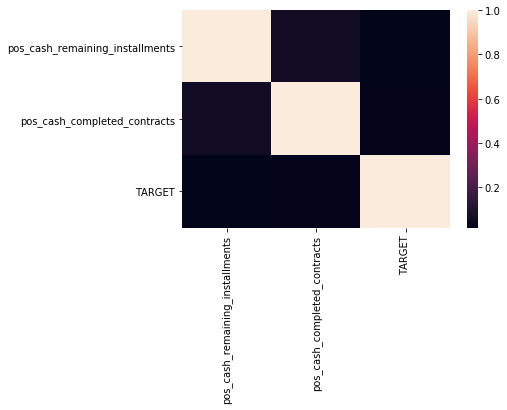

In [14]:
sns.heatmap(credit_eng_corr, 
            xticklabels=credit_eng_corr.columns,
            yticklabels=credit_eng_corr.columns)

In [15]:
features.head()

,SK_ID_CURR,pos_cash_remaining_installments,pos_cash_completed_contracts
0,182943,5.0,1.0
1,367990,4.0,2.0
2,397406,0.0,6.0
3,269225,24.0,5.0
4,334279,2.0,4.0


## Solution 5

### Hand crafted features

In [16]:
pos_cash_balance['pos_cash_paid_late'] = (pos_cash_balance['SK_DPD'] > 0).astype(int)
pos_cash_balance['pos_cash_paid_late_with_tolerance'] = (pos_cash_balance['SK_DPD_DEF'] > 0).astype(int)
groupby = pos_cash_balance.groupby(['SK_ID_CURR'])

In [17]:
def last_k_installment_features(gr, periods):
    gr_ = gr.copy()

    features = {}
    for period in periods:
        if period > 10e10:
            period_name = 'all_installment_'
            gr_period = gr_.copy()
        else:
            period_name = 'last_{}_'.format(period)
            gr_period = gr_[gr_['MONTHS_BALANCE'] >= (-1) * period]

        features = add_features_in_group(features, gr_period, 'pos_cash_paid_late',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'pos_cash_paid_late_with_tolerance',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD',
                                             ['sum', 'mean', 'max', 'min', 'median'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD_DEF',
                                             ['sum', 'mean', 'max', 'min','median'],
                                             period_name)
    return features

In [18]:
features = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})
func = partial(last_k_installment_features, periods=[6, 12, 24, 60, 10e16])
g = parallel_apply(groupby, func, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

100%|██████████| 34/34.0 [11:14<00:00, 19.84s/it]


In [19]:
features.head()

,SK_ID_CURR,all_installment_SK_DPD_DEF_max,all_installment_SK_DPD_DEF_mean,all_installment_SK_DPD_DEF_median,all_installment_SK_DPD_DEF_min,all_installment_SK_DPD_DEF_sum,all_installment_SK_DPD_max,all_installment_SK_DPD_mean,all_installment_SK_DPD_median,all_installment_SK_DPD_min,...,last_6_SK_DPD_DEF_sum,last_6_SK_DPD_max,last_6_SK_DPD_mean,last_6_SK_DPD_median,last_6_SK_DPD_min,last_6_SK_DPD_sum,last_6_pos_cash_paid_late_count,last_6_pos_cash_paid_late_mean,last_6_pos_cash_paid_late_with_tolerance_count,last_6_pos_cash_paid_late_with_tolerance_mean
0,182943,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0,0.0,0.0,0.0,0.0,0,5,0.0,5,0.0
1,367990,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN
2,397406,6,0.146789,0.0,0,16,485,37.706422,0.0,0,...,0,0.0,0.0,0.0,0.0,0,9,0.0,9,0.0
3,269225,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0,0.0,0.0,0.0,0.0,0,6,0.0,6,0.0
4,334279,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0,0.0,0.0,0.0,0.0,0,12,0.0,12,0.0


### Last loan features

In [20]:
def last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)
    last_installment_id = gr_[gr_['MONTHS_BALANCE'] == gr_['MONTHS_BALANCE'].max()]['SK_ID_PREV']
    gr_ = gr_[gr_['SK_ID_PREV'].isin(last_installment_id)]

    features={}
    features = add_features_in_group(features, gr_, 'pos_cash_paid_late',
                                         ['count', 'sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'pos_cash_paid_late_with_tolerance',
                                         ['sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD_DEF',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    return features

In [21]:
g = parallel_apply(groupby, last_loan_features, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

100%|██████████| 34/34.0 [06:00<00:00, 10.62s/it]


In [22]:
features.head()

,SK_ID_CURR,all_installment_SK_DPD_DEF_max,all_installment_SK_DPD_DEF_mean,all_installment_SK_DPD_DEF_median,all_installment_SK_DPD_DEF_min,all_installment_SK_DPD_DEF_sum,all_installment_SK_DPD_max,all_installment_SK_DPD_mean,all_installment_SK_DPD_median,all_installment_SK_DPD_min,...,last_loan_SK_DPD_max,last_loan_SK_DPD_mean,last_loan_SK_DPD_min,last_loan_SK_DPD_std,last_loan_SK_DPD_sum,last_loan_pos_cash_paid_late_count,last_loan_pos_cash_paid_late_mean,last_loan_pos_cash_paid_late_sum,last_loan_pos_cash_paid_late_with_tolerance_mean,last_loan_pos_cash_paid_late_with_tolerance_sum
0,182943,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0,0.0,0,0.0,0,33,0.0,0,0.0,0
1,367990,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0,0.0,0,0.0,0,19,0.0,0,0.0,0
2,397406,6,0.146789,0.0,0,16,485,37.706422,0.0,0,...,0,0.0,0,0.0,0,17,0.0,0,0.0,0
3,269225,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0,0.0,0,0.0,0,10,0.0,0,0.0,0
4,334279,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0,0.0,0,0.0,0,48,0.0,0,0.0,0


### Trend features

In [23]:
def trend_in_last_k_installment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)

    features = {}
    for period in periods:
        gr_period = gr_[gr_['MONTHS_BALANCE'] >= (-1) * period]

        features = add_trend_feature(features, gr_period,
                                         'SK_DPD', '{}_period_trend_'.format(period)
                                         )
        features = add_trend_feature(features, gr_period,
                                         'SK_DPD_DEF', '{}_period_trend_'.format(period)
                                         )
    return features

def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features

In [24]:
func = partial(trend_in_last_k_installment_features, periods=[6, 12, 24, 60])
g = parallel_apply(groupby, func, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

100%|██████████| 34/34.0 [07:18<00:00, 12.90s/it]


In [25]:
def last_k_instalment_fractions(old_features, fraction_periods):
    features = old_features[['SK_ID_CURR']].copy()
    
    for short_period, long_period in fraction_periods:
        short_feature_names = _get_feature_names(old_features, short_period)
        long_feature_names = _get_feature_names(old_features, long_period)
        
        for short_feature, long_feature in zip(short_feature_names, long_feature_names):
            old_name_chunk = '_{}_'.format(short_period)
            new_name_chunk ='_{}by{}_fraction_'.format(short_period, long_period)
            fraction_feature_name = short_feature.replace(old_name_chunk, new_name_chunk)
            features[fraction_feature_name] = old_features[short_feature]/old_features[long_feature]
    return features.fillna(0.0)

def _get_feature_names(features, period):
    return sorted([feat for feat in features.keys() if '_{}_'.format(period) in feat])

In [26]:
g = last_k_instalment_fractions(features, fraction_periods=[(6, 12), (6, 24), (12,24), (12, 60)])
features = features.merge(g, on='SK_ID_CURR', how='left')

display(features.head())

,SK_ID_CURR,all_installment_SK_DPD_DEF_max,all_installment_SK_DPD_DEF_mean,all_installment_SK_DPD_DEF_median,all_installment_SK_DPD_DEF_min,all_installment_SK_DPD_DEF_sum,all_installment_SK_DPD_max,all_installment_SK_DPD_mean,all_installment_SK_DPD_median,all_installment_SK_DPD_min,...,last_12by60_fraction_SK_DPD_DEF_sum,last_12by60_fraction_SK_DPD_max,last_12by60_fraction_SK_DPD_mean,last_12by60_fraction_SK_DPD_median,last_12by60_fraction_SK_DPD_min,last_12by60_fraction_SK_DPD_sum,last_12by60_fraction_pos_cash_paid_late_count,last_12by60_fraction_pos_cash_paid_late_mean,last_12by60_fraction_pos_cash_paid_late_with_tolerance_count,last_12by60_fraction_pos_cash_paid_late_with_tolerance_mean
0,182943,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.268293,0.0,0.268293,0.0
1,367990,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,397406,6,0.146789,0.0,0,16,485,37.706422,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.265823,0.0,0.265823,0.0
3,269225,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.200000,0.0
4,334279,0,0.000000,0.0,0,0,0,0.000000,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.284314,0.0,0.284314,0.0


In [27]:
X = X.merge(features, on='SK_ID_CURR',how='left')
X_corr = abs(X.corr())
X_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                                          1.000000
last_24_pos_cash_paid_late_with_tolerance_mean                  0.057825
last_loan_pos_cash_paid_late_with_tolerance_mean                0.050549
last_12_pos_cash_paid_late_with_tolerance_mean                  0.050392
last_60_pos_cash_paid_late_with_tolerance_mean                  0.047365
all_installment_pos_cash_paid_late_with_tolerance_mean          0.047050
last_6_pos_cash_paid_late_with_tolerance_mean                   0.046611
last_24_pos_cash_paid_late_mean                                 0.046461
last_12by24_fraction_SK_DPD_max                                 0.043725
last_12by60_fraction_SK_DPD_max                                 0.043246
last_12by24_fraction_SK_DPD_sum                                 0.042951
last_loan_pos_cash_paid_late_mean                               0.042649
last_12by24_fraction_SK_DPD_DEF_max                             0.042525
last_12by60_fraction_SK_DPD_sum                    

In [28]:
regex = '12by60_fraction'
X_corr_truncated = X_corr.sort_values('TARGET', ascending=False).filter(regex=regex, axis=0)
X_corr_truncated['TARGET']

last_12by60_fraction_SK_DPD_max                                 0.043246
last_12by60_fraction_SK_DPD_sum                                 0.042434
last_12by60_fraction_SK_DPD_DEF_max                             0.042206
last_12by60_fraction_SK_DPD_DEF_sum                             0.041197
last_12by60_fraction_SK_DPD_DEF_mean                            0.034984
last_12by60_fraction_pos_cash_paid_late_with_tolerance_mean     0.034644
last_12by60_fraction_SK_DPD_mean                                0.034138
last_12by60_fraction_pos_cash_paid_late_mean                    0.033832
last_12by60_fraction_pos_cash_paid_late_with_tolerance_count    0.014036
last_12by60_fraction_pos_cash_paid_late_count                   0.014036
last_12by60_fraction_SK_DPD_DEF_median                          0.006401
last_12by60_fraction_SK_DPD_median                              0.005647
last_12by60_fraction_SK_DPD_min                                 0.000471
last_12by60_fraction_SK_DPD_DEF_min                

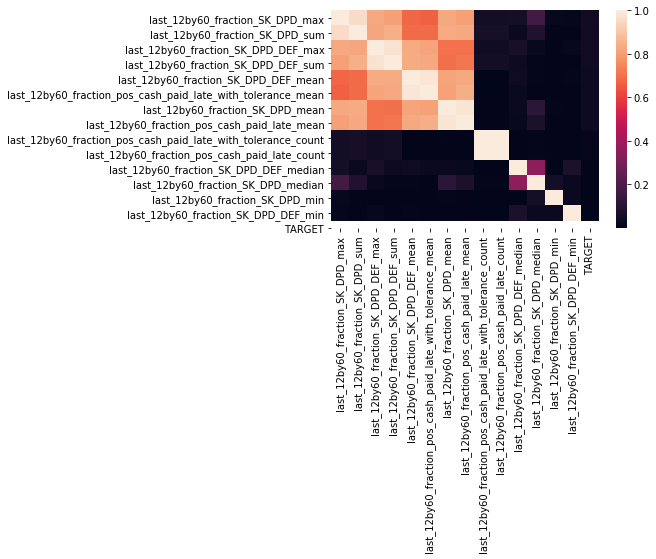

In [29]:
colnames = X_corr_truncated.index.tolist() + ['TARGET']
sns.heatmap(X_corr_truncated[colnames], 
            xticklabels=colnames,
            yticklabels=colnames)